# Computer vision projects on classifying traffic sign. 


: data augmentation, why this CNN and plot the probability of the knn top5 

From exporation, there are 34799 training sets and 12630 testing sets. 
Each of the image has 32*32*3.
Roughly around 40+ classes.
The goal is to leverage a unbalance and relativity speaking small dataset to classify with deep neuarl networking.

Recall from deep learning foundations course from deeplearning.ai, classic machine learning requires around 100-10,000 samples and deep learning requires around 1 million sample. 

Given neural network does not require any data balance having each class, I would like to see the difference between data split and also data size. 

In [1]:
# Load pickled data
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import cv2
import tensorflow as tf
from sklearn.utils import shuffle
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

training_file = "./traffic-signs-data/train.p"
validation_file = "./traffic-signs-data/test.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
    
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, Y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("Y_valid shape", X_valid.shape)
print("Y_valid shape", Y_valid.shape)
print("Y_train shape", X_train.shape)
print("Y_test shape", X_test.shape)

X_train shape (34799, 32, 32, 3)
X_test shape (12630, 32, 32, 3)
Y_valid shape (12630, 32, 32, 3)
Y_valid shape (12630,)
Y_train shape (34799, 32, 32, 3)
Y_test shape (12630, 32, 32, 3)


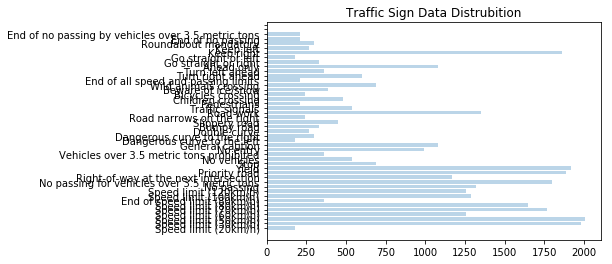

In [2]:
signnames = pd.read_csv('signnames.csv')
label_names = list(signnames)
y_train_df = pd.DataFrame()
y_train_df['label'] = y_train

# Get current size
figsize=(15, 7)
 
# Prints: [8.0, 6.0]

item, count = np.unique(y_train, return_counts=True)
freq = np.array((item, count)).T
plt.figure(11)
plt.yticks(range(len(y_train)), signnames.SignName)
#plt.yticks(list(map(lambda x: label_dict[x], y_train['label'].value_counts().index.tolist())))            
plt.barh(item, count, alpha=0.3)
plt.title('Traffic Sign Data Distrubition')

plt.show()

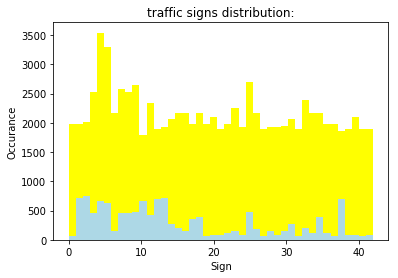

In [35]:
fig, ax = plt.subplots()
plt.xlabel('Sign')
plt.ylabel('Occurance')
plt.title('traffic signs distribution:')
ax.hist(y_train, bins=43, color='yellow')
ax.hist(y_test, bins=43, color='red')
ax.hist(Y_valid, bins=43, color='lightblue')
plt.show()

From the exploration, there the training and testing dataset obtains about the same ratios of classes.


#Question 1
Describe how you preprocessed the data. Why did you choose that technique?

1. I am planning to preprocess my image by converting into greyscale that can save a lot of computer power from 3 channels to 1, since I dont have GPU on my laptop nor planning to train on cloud. 
Next step is to normalizied dataset, the process would allows each dimensions have a similar scale


there are always different approches on this: 
1. loop image one by one with CV2 (easiest way)
2. passing through normalizing (pixel - 128)/ 128, then img.astype(np.float32), passing through the CV2, and finally reshape from 32,32,3 to 32,32,1
X_train_gray = np.zeros((N, 32, 32, 1), dtype=np.float32)

- in your for loop
X_train_gray[i] = normalize_img(element)

https://discourse-cdn-sjc3.com/udacity/uploads/default/original/4X/5/7/1/5719666845aa31c56610cb2c27f4a16c7fc4c022.png
3. converting RGB to YCbCr (Y: Luminance; Cb: Chrominance-Blue; and Cr: Chrominance-Red are the components. Luminance is very similar to the grayscale version of the original image)


3.from image_preprocessor import ImagePreprocessor

image_preprocessor = ImagePreprocessor()
image_preprocessor.call() 

In [6]:
def translation(img, x=1, y=1):
    row,cols,_=img.shape
    M = np.float32(([1,0,x],[0,1,y]))
    return cv2,waroAffine(img,M(cols, rows)).astype()

def rotation(img,angle= 10,scale=1):
    rows,cols,_ = img.shape
    martrix = cv2.getRotationMatrix2D((cols/2,rows/2),angle,scale)
    return cv2.warpAffine(img,matrix,(cols, rows)).astype(np.unit8)

def brightness_augment(img, value = 30):

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h,s,v = cv2.split(hsv)
    lim = 255- value
    v[v>lim]= 255
    v[v<=lim] += value
    hsv = cv2.merge([h,s,v])
    img = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)
    return img

import random
import numpy as np
def augment_images(image, count = 1):
    random_number = [1,2]
    augment_choice = np.random.choice(random_number)
    augment_choice = 2
    
    rotation_angle = int(10*(1+count/4))
    brightness_value = int(30*(1+count/4))
    
    if augment_choice ==1:
        image= rotation(image,rotation_angle)
    else:
        image = brightness_augment(image,brightness_value)
    return image

def balance_augment(X,Y, maximum_number = 1800, threshold = 1.0):
    X_aug = []
    Y_aug = []
    unique_numbers, counts = np.unique(Y, return_counts = True)
    for count, number in zip(counts, unique_numbers):
        augment_number = maximum_number/count
        if augment_number > threshold:
            augment_number = int(augment_number)
            for i in range(augment_number):
                indices = (Y == number).nonzero()[0]
                for j in indices:
                    new_images = augment_images(X[j],i)
                    X_aug.append(new_images)
                    Y_aug.append(number)
    X_aug = np.array(X_aug)
    Y_aug = np.array(Y_aug)
    print(X_aug.shape)
    X = np.append(X,X_aug, axis = 0)
    Y = np.append(Y,Y_aug, axis = 0)
    return X,Y


X_train, y_train = balance_augment(X_train, y_train)
print("data balance and augmentation done")

In [8]:
def normalize(image):
    return image.astype(float) / 255.0

def preprocess(img):
    image= [] 
    for i in img:
        i = np.dot(i[...,:3], [0.299, 0.587, 0.114])
        image.append(normalize(i))
    return np.array(image).reshape((-1,32,32,1))


X_train= preprocess(X_train)
X_test= preprocess(X_test)
X_valid = preprocess(X_valid)
print("data preprocessing done")

In [33]:
X_train.shape

(92636, 32, 32, 1)

8
42
37
16
4
6
3
37
22
9


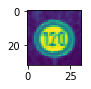

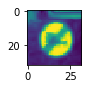

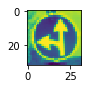

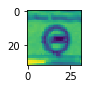

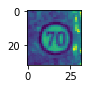

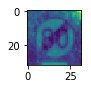

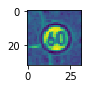

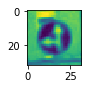

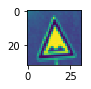

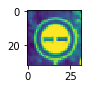

In [29]:
#showing augmented images and its classes
for i in range(10):
    index = np.random.randint(34799, (len(X_train)))
    image = X_train[index].squeeze()
    
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    print(y_train[index])

#data = X_train
#random = np.random.randint(34799,(len(data)))
#plt.imshow(data[random].squeeze(), cmap="gray")
#plt.imshow(X_train)

In [ ]:
def histogram_equalization(img_array):
    l,w,h = img_array.shape[1:]
    equalized_images = np.empty((0,l,w,h))
    for i in range(len(img_array)):
        img_yuv = cv2.cvtColor(img_array[i], cv2.COLOR_BGR2YUV)
        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
        img_out = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        img_out = np.reshape(img_out, (1,l,w,h))
        equalized_images = np.append(equalized_images, img_out,axis = 0)
    return equalized_images 

#X_train = histogram_equalization(X_train)

#Question 2
Describe how you set up the training, validation and testing data for your model.
Once I have my data preprocess, next splitting the data into 80,20

In [38]:
#shuffle the data afterwards 
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.02, random_state=0)


print("X_train shape", X_train.shape)
print("X_test shape", X_test.shape)
print("Y_valid shape", X_validation.shape)

X_train shape (90783, 32, 32, 1)
X_test shape (12630, 32, 32, 1)
Y_valid shape (1853, 32, 32, 1)


ValueError: x must have 2 or fewer dimensions

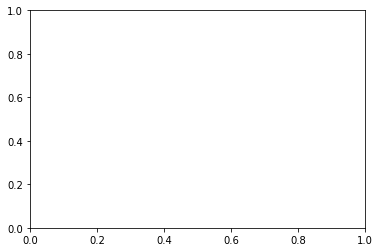

In [39]:
n_classes = np.unique(X_train).size

def print_class_distribution():
    plt.hist(X_train, bins=n_classes)
    plt.title("Class distribution")
    plt.xlabel("Class label")
    plt.ylabel("Frequency")
    plt.show()

    class_dist, classes = np.histogram(X_train, bins=np.arange(n_classes+1), density=True)
    print("Ideal distribution should be : " , 100. / n_classes)
    for i in np.arange(n_classes):
        print("Class ", classes[i], " : ", class_dist[classes[i]]/n_classes * 100.0)

print_class_distribution()

I was able to tune the suggested algorithm have a 93.1% validation, and testing and training with a 100%, yet when new images from web are test on the classifer, it turns out having only 1 right out of 5. 
therefore, I am going to have more data by augmenting more for the classes that has lesser dataset on.

# Question 3
What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.) For reference on how to build a deep neural network using TensorFlow, see Deep Neural Network in TensorFlow from the classroom


I am using a 4 layer network :
Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
Activation:relu
Pooling. Input = 28x28x6. Output = 14x14x6.
Layer 2: Convolutional. Output = 10x10x16.
Activation: relu
Pooling. Input = 10x10x16. Output = 5x5x16.
Layer 3: Convolutional. Output = 1x1x400.
Activation: relu
Flatten. Input = 5x5x16. Output = 400
Flatten x: Input = 1x1x400. Output = 400.
Concat layer2flat and x. Input = 400 + 400. Output = 800
Dropout
Layer 3: Convolutional. Output = 1x1x400.
Dropout
Layer 4: Fully Connected. Input = 800. Output = 43.

#Question 4
How did you train your model?
 about the optimizer used, and some of the hyperparameters (learning rate, keep_prob).



EPOCHS = 30
BATCH_SIZE = 64

In [40]:
import tensorflow as tf
EPOCHS = 10
BATCH_SIZE = 128
n_classes = len(np.unique(y_train))

In [43]:
#applying leNet in Tensorflow

from tensorflow.contrib.layers import flatten
def LeNet(x):    
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Layer 3: Convolutional. Output = 1x1x128
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 128), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 2, 2, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(128), name="b3")
    x = tf.nn.bias_add(x, b3)
    
    # TODO: Layer 4: Convolutional. Output = 2X2X400
    W4 = tf.Variable(tf.truncated_normal(shape=(5, 5, 128, 400), mean = mu, stddev = sigma), name="W4")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b4 = tf.Variable(tf.zeros(400), name="b4")
    x = tf.nn.bias_add(x, b4)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)
    x = flatten(x)

    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # TODO: Layer 5: Fully Connected. Input = 800. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(1600, 400), mean = mu, stddev = sigma), name="W5")
    b5 = tf.Variable(tf.zeros(400), name="b5")    
    x = tf.add(tf.matmul(x, W5, name = 'mult1'), b5)
    
    x = tf.nn.relu(x, name = 'relu1')
    x = tf.nn.dropout(x, keep_prob, name = "dropout1")
    
    
    #W6 = tf.Variable(tf.truncated_normal(shape=(400, 43), mean = mu, stddev = sigma), name="W5")
    #b6 = tf.Variable(tf.zeros(43), name="b5")      
    logits = tf.add(tf.matmul(x,W5, name= 'mult2'),b5)

    return logits


In [48]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # TODO: Activation.
    x = tf.nn.relu(x)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W3 = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, W3), b3)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W4 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W4), b4)
    
    # TODO: Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    W5 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, W5), b5)
    
    return logits

print('done')

done


In [49]:
x = tf.placeholder(tf.float32, shape=[None,32,32,1])
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)
                   
#Invoke LeNet function by passing features
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)



layer 1 shape: (?, 28, 28, 6)


In [50]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

print('done')

done


In [51]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.832

EPOCH 2 ...
Validation Accuracy = 0.913

EPOCH 3 ...
Validation Accuracy = 0.930

EPOCH 4 ...
Validation Accuracy = 0.951

EPOCH 5 ...
Validation Accuracy = 0.963

EPOCH 6 ...
Validation Accuracy = 0.971

EPOCH 7 ...
Validation Accuracy = 0.974

EPOCH 8 ...
Validation Accuracy = 0.982

EPOCH 9 ...
Validation Accuracy = 0.979

EPOCH 10 ...
Validation Accuracy = 0.983

Model saved


In [52]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(X_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

Test Set Accuracy = 0.925


#Question 5
What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem.

This has been a back and forth challenge where I truly invest my time on data agumentations vs trying other neural network and tuning their parameters. 

This takes me for a few weeks to get to this acceptable accuracy.

#Question 6
Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?

Those images are search under German traffic sign and somehow it shouldnt be any harder or confusing than pervious training ones. I thought of using Hong Kong  traffic sign where there is an english and chinese character side by side but turns out it totally doesnt work at all.


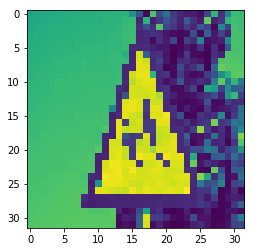

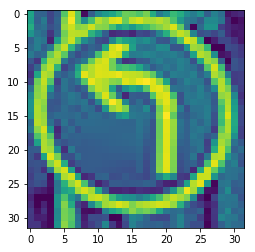

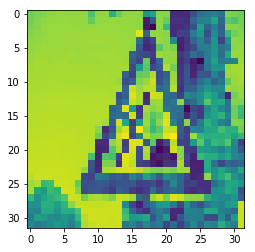

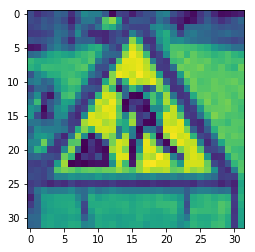

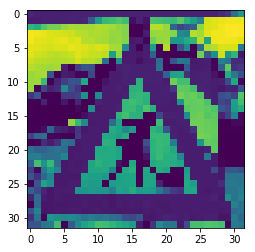

In [53]:
import glob
my_image = np.zeros((5,32,32,1))
for i, img in enumerate(glob.glob('./traffic-signs-data/germansign/image*.jpg')):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = (image -128/128)
    my_image[i][:][:][:] =np.array(image)[...,np.newaxis]
    plt.imshow(image)
    plt.show()
    #figures[i] = my_image[i].squeeze()
    #plot_figures(figures)
labels = np.array([28,35,25,25,25], dtype = 'uint8')

In [54]:
my_single_item_array = []
my_single_item_label_array = []

for i in range(5):
    my_single_item_array.append(my_image[i])
    my_single_item_label_array.append(labels[i])

    with tf.Session() as sess2:
        sess2.run(tf.global_variables_initializer())
#         saver = tf.train.import_meta_graph('./lenet.meta')
        saver.restore(sess2, tf.train.latest_checkpoint('.'))
        my_accuracy = evaluate(my_image, labels)
        print('Image {}'.format(i+1))
        print("Image Accuracy = {:.3f}".format(my_accuracy))
        print()

Image 1
Image Accuracy = 0.400

Image 2
Image Accuracy = 0.400

Image 3
Image Accuracy = 0.400

Image 4
Image Accuracy = 0.400

Image 5
Image Accuracy = 0.400



Test Accuracy = 0.400


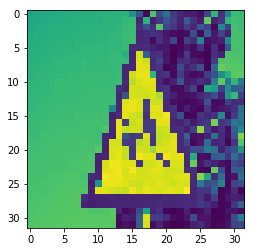

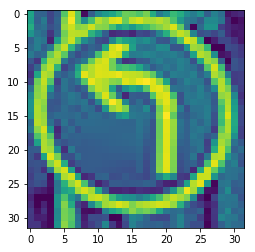

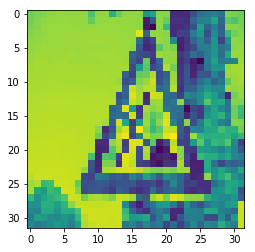

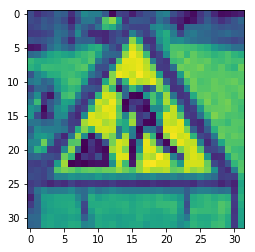

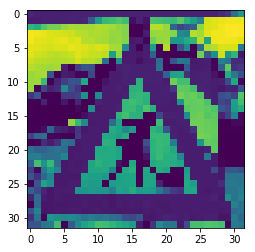

In [55]:
with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(my_image, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

    
for i, image in enumerate(my_image):
    #grid = plt.subplot(len(my_image)/4,5,i+1)
    image = image.squeeze()
    #grid.imshow(image), plt.axis('off')
    plt.imshow(image)
    plt.show()
    #plt.title(signnames[str(outputclass[i])])

plt.show()

In [56]:
logits = LeNet(x)
softmax = tf.nn.softmax(logits)

sess2 = tf.get_default_session()

with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(my_image, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    result = sess2.run(softmax, feed_dict={x: my_image,keep_prob: 1.})
    values, indices = tf.nn.top_k(result, 5)
    
    predictions  = sess2.run(values)
    predictionIndicies  = sess2.run(indices)
    print("softmax probabilties for top 5 predictions are:")
    print(predictions)
    print("predictionIndicies")
    print(predictionIndicies)
    

layer 1 shape: (?, 28, 28, 6)
Test Accuracy = 0.400
softmax probabilties for top 5 predictions are:
[[9.7850454e-01 2.1492504e-02 2.2831002e-06 6.1888244e-07 1.1212745e-08]
 [9.7420746e-01 2.5560616e-02 1.3181628e-04 9.9349192e-05 5.6553017e-07]
 [1.0000000e+00 2.6875245e-08 6.2926830e-12 1.0749343e-12 5.9409042e-13]
 [9.9995720e-01 4.2153661e-05 5.9336696e-07 7.3147211e-10 3.9399495e-10]
 [9.9972600e-01 2.7399740e-04 2.1141257e-10 5.1993076e-12 6.8294057e-13]]
predictionIndicies
[[12 38 28 40  3]
 [38 40 12 42 15]
 [38 24 12  8 40]
 [38 41 24 40  8]
 [40 38 41 39 24]]


layer 1 shape: (?, 28, 28, 6)
Test Accuracy = 0.400
softmax probabilties for top 5 predictions are:
[[1.00000000e+00 1.05499972e-20 4.85770751e-22 1.03453794e-22
  1.10614041e-28]
 [1.00000000e+00 9.25557732e-17 7.25934481e-20 6.58373923e-20
  3.24463453e-21]
 [1.00000000e+00 9.88511051e-10 2.09989665e-11 5.12851006e-15
  2.13508458e-16]
 [9.99999881e-01 7.22369791e-08 6.32443842e-15 3.77818072e-15
  2.59880979e-18]
 [1.00000000e+00 5.73010960e-16 2.84897623e-21 1.52098984e-22
  2.10848857e-23]]
predictionIndicies
[[42 17  5  6 41]
 [42  6  7 17 37]
 [42 17  6  3 41]
 [42  6 41  3 17]
 [42  6 41 17 36]]


TypeError: 'numpy.int32' object is not iterable

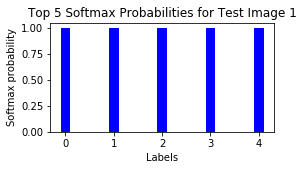

In [57]:
logits = LeNet(x)
softmax = tf.nn.softmax(logits)

sess2 = tf.get_default_session()

with tf.Session() as sess2:
    sess2.run(tf.global_variables_initializer())
    saver.restore(sess2, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(my_image, labels)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    result = sess2.run(softmax, feed_dict={x: my_image,keep_prob: 1.})
    values, indices = tf.nn.top_k(result, 5)
    
    predictions  = sess2.run(values)
    predictionIndicies  = sess2.run(indices)
    print("softmax probabilties for top 5 predictions are:")
    print(predictions)
    print("predictionIndicies")
    print(predictionIndicies)
    
top_k_values = predictions[0]
top_k_indices = predictionIndicies[1]

ind = np.arange(5) 

for i in range(5):
    plt.figure(figsize=(4,2))
    values = top_k_values[i]
    plt.bar(ind, values, 0.2, color='b')
    plt.ylabel('Softmax probability')
    plt.xlabel('Labels')
    plt.title('Top 5 Softmax Probabilities for Test Image {}'.format(str(i+1)))
    plt.xticks(ind, tuple(top_k_indices[i]))

plt.show()
    #bar(np.arange(n_classes), result[(i-1)//2]) 
    #plt.figure()
    #plt.bar(result.indices[i],result.values[i], align='center', alpha=0.5)
    #plt.xlim([0,42])
    #plt.title("{}, label = {}".format( names[i], Y_test_web[i] ) )